In [ ]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir
from IPython.display import Math
from matplotlib import pyplot as plt, rc, cycler
import seaborn as sns
palette = sns.color_palette("colorblind")
palette[3], palette[5] = palette[5], palette[3]
rc("axes", prop_cycle=cycler(color=palette))
alpha=0.5
import numpy as np
from pycbc.inference import models

for model_name in models.models:
    print(model_name)
from pycbc.inference import models, sampler
from pycbc import distributions as dists
from scipy import stats as spst
from pycbc.catalog import Merger
from pycbc import psd, frame, filter as filt
from astropy.utils.data import download_file
from pycbc.inference import models, sampler
from pycbc import distributions as dists
import copy
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image

test_eggbox
test_normal
test_rosenbrock
test_volcano
test_prior
gaussian_noise
marginalized_phase
marginalized_polarization
brute_parallel_gaussian_marginalize
single_template
relative


In [ ]:
from pycbc.catalog import Merger
from pycbc import psd, frame, filter as filt
from astropy.utils.data import download_file

m = Merger("GW190521", source="GWTC-2")

# List of observatories we'll analyze
ifos = ["H1", "L1", "V1"]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}
channel_name = "{}:GWOSC-4KHZ_R1_STRAIN

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    # Note: The GWOSC frames feature a huge glitch in L1 that significantly
    #       impacts parameter inference. We will use "cleaned" frames here,
    #       which have had the glitch removed.
    #url = "https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW170817/v3/{}-{}_GWOSC_4KHZ_R1-1187006835-4096.gwf"
    url = "https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/{}-{}_GWOSC_4KHZ_R1-1242440920-4096.gwf"
    fname = download_file(url.format(ifo[0], ifo), cache="update")
    data_filenames[ifo] = fname
    
    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = frame.read_frame(fname, "{}:GWOSC-4KHZ_R1_STRAIN".format(ifo), 
                          start_time=int(m.time - 260),
                          end_time=int(m.time + 40))


    ts = filt.highpass(ts, 15.0)                     # Remove low frequency content
    ts = filt.resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    PSD = psd.interpolate(ts.psd(4), ts.delta_f)
    PSD = psd.inverse_spectrum_truncation(PSD, int(4 * PSD.sample_rate), 
                                          trunc_method='hann',
                                          low_frequency_cutoff=20.0)
    psds[ifo] = PSD


Processing H1 data
Processing L1 data
Processing V1 data


In [ ]:
model_config = """
[model]
name = single_template
low-frequency-cutoff = 14.
"""

In [ ]:
data_config = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 12
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:{chan} L1:{chan} V1:{chan}
""".format(event_tc=Merger("GW190521", source="GWTC-2").time,
           h1file=data_filenames['H1'],
           l1file=data_filenames['L1'],
           v1file=data_filenames['V1'],
           chan=channel_name[3:])

In [ ]:
!echo '{data_config}' > data.ini
!cat data.ini


[data]
instruments = H1 L1 V1
trigger-time = 1242442967.4
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 12
pad-data = 8
sample-rate = 2048
frame-files = H1:/root/.astropy/cache/download/url/ce625a89e5633bcc756e4b6cfe5cb604/contents L1:/root/.astropy/cache/download/url/a52d44bbb03e86f558de5e9fbadd2e61/contents V1:/root/.astropy/cache/download/url/0013b2baceb083a3551c425c5c566a8b/contents
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN



In [ ]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = single_template
low-frequency-cutoff = 14.



In [ ]:
prior_config = """

[variable_params]
distance =
inclination =
delta_tc =
ra =
dec =

[static_params]
mass1 = 157.2
mass2 = 114.9
f_lower = 14
approximant = IMRPhenomD
polarization = 0

[prior-distance]
name = uniform_radius
min-distance = 2000
max-distance = 7000

[prior-inclination]
name = sin_angle
max-inclination = 2
min-inclination = 0

[prior-delta_tc]
name = uniform
min-delta_tc = 0.04
max-delta_tc = 0.1

[prior-ra+dec]
name = uniform_sky

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [ ]:
!echo '{prior_config}' > prior.ini
!cat prior.ini



[variable_params]
distance =
inclination =
delta_tc =
ra =
dec =

[static_params]
mass1 = 157.2
mass2 = 114.9
f_lower = 14
approximant = IMRPhenomD
polarization = 0

[prior-distance]
name = uniform_radius
min-distance = 2000
max-distance = 7000

[prior-inclination]
name = sin_angle
max-inclination = 2
min-inclination = 0

[prior-delta_tc]
name = uniform
min-delta_tc = 0.04
max-delta_tc = 0.1

[prior-ra+dec]
name = uniform_sky

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [ ]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 500
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [ ]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 500
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



In [ ]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference.hdf \
    --seed 28572013 \
    --nprocesses 8 \
    --force    

2021-01-22 10:28:12,003 Using seed 28572013
2021-01-22 10:28:12,004 Running with CPU support: 1 threads
2021-01-22 10:28:12,004 Reading configuration file
2021-01-22 10:28:12,006 Setting up model
2021-01-22 10:28:12,007 Setting up priors for each parameter
2021-01-22 10:28:12,008 No sampling_params section read from config file
2021-01-22 10:28:12,008 Loading waveform transforms
2021-01-22 10:28:12,011 Determining analysis times to use
2021-01-22 10:28:12,011 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 10:28:12,011 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 10:28:12,012 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 10:28:12,012 Reading Frames
2021-01-22 10:28:28,268 Highpass Filtering
2021-01-22 10:28:28,337 Converting to float64
2021-0

In [ ]:
!ls -lh inference.hdf

-rw-r--r-- 1 root root 259M Jan 22 10:34 inference.hdf


In [ ]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr \

2021-01-22 10:35:26,598 Reading input file inference.hdf
2021-01-22 10:35:26,601 Loading samples
2021-01-22 10:35:26,612 Loaded 2500 samples
2021-01-22 10:35:26,613 Getting samples for colorbar
2021-01-22 10:35:26,618 Plotting
2021-01-22 10:35:30,283 Done


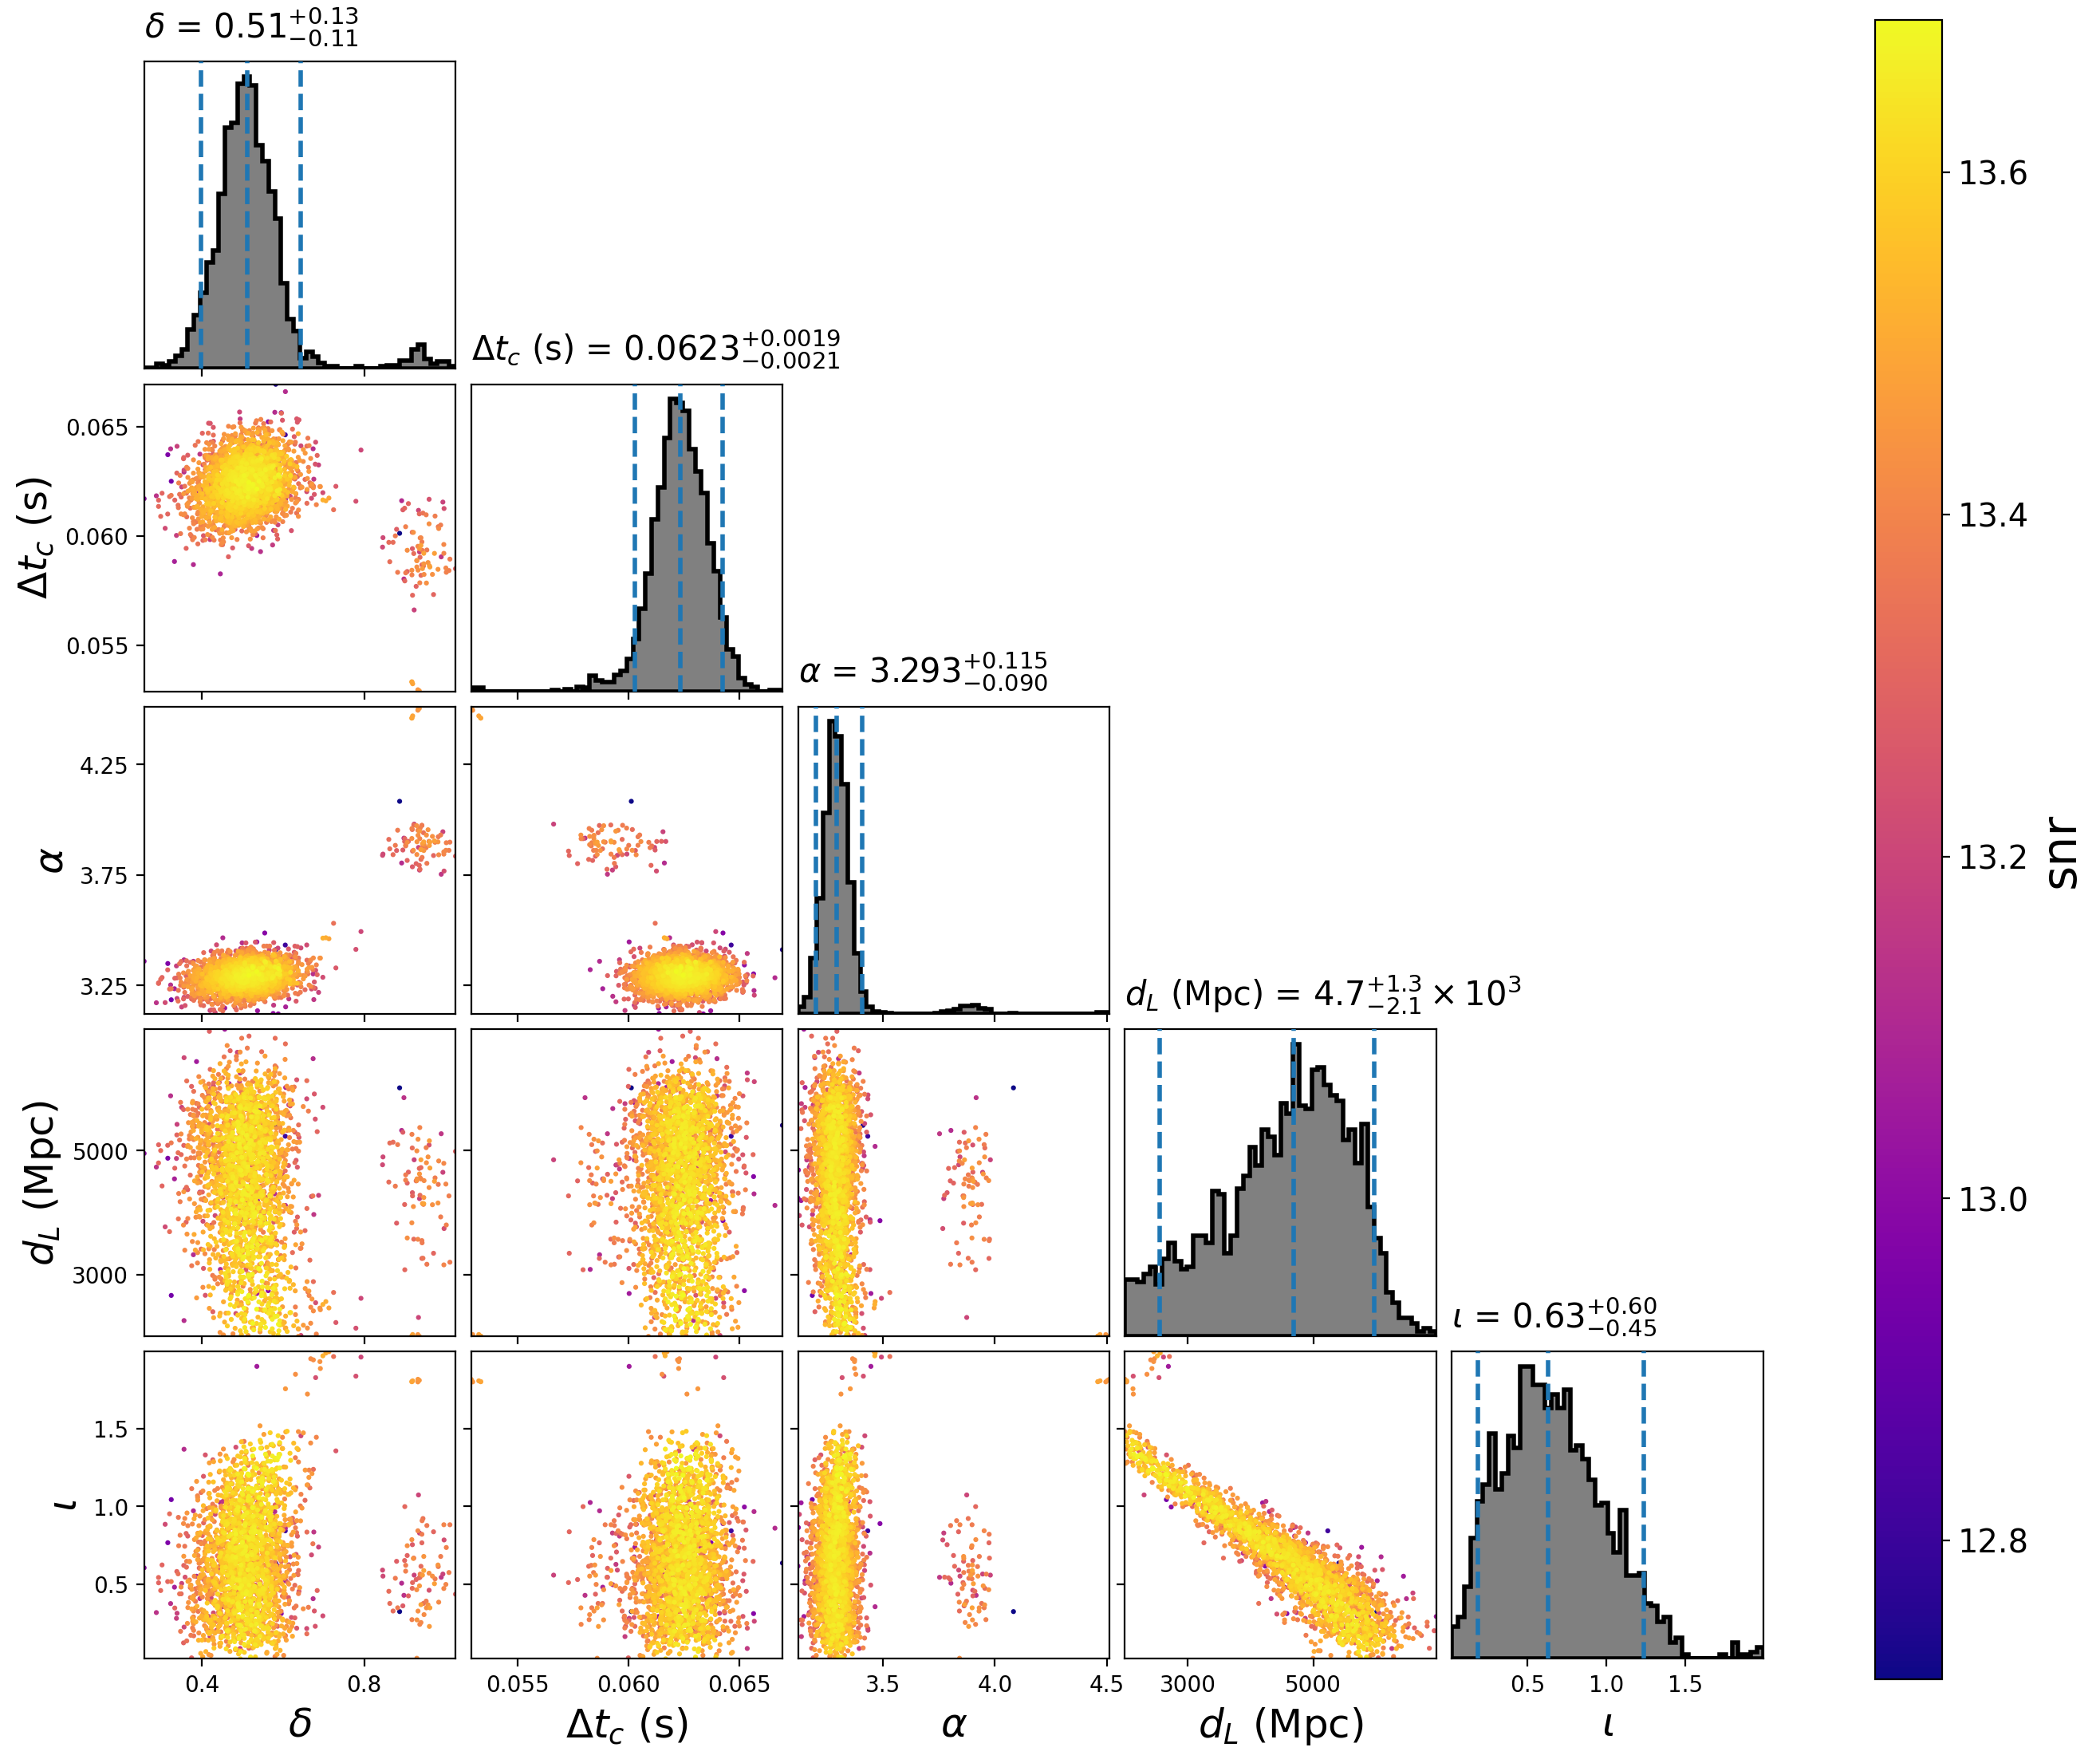

In [ ]:
Image('posterior.png', height=480)

## 6. Estimate the masses of GW170817 ##

In the previous example we quickly estimated the extrinsic parameters of GW170817 by fixing the intrinsic. This was fast, since it did not require regenerating a waveform for each likelihood evaluation. Now let's try estimating the masses of GW170817. This is generally slower, since it requires generating a waveform on each likelihood call. However, in the example below, we'll use the [relative binning model](https://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.relbin.Relative). This uses a technique presented in [Zackay et al.](https://arxiv.org/abs/1806.08792). Basically, a reference waveform is used that's close to the peak likelihood. A linear approximation is used to interpolate the likelihood around this waveform, reducing the number of frequency points that we need to evaluate, and speeding up the analysis.

To do this, we'll use the same `data.ini` and `sampler.ini` files as above. We'll change the `model` to the `relative` one and provide the necessary arguments to generate the fiducial waveform. We'll make the chirp mass (`mchirp`) and symmetric mass ratio (`eta`) the variable parameters; for speed, we'll fix the extrinsic parameters.

### 6.1 Get the extrinsic parameters

For speed, we'll fix the extrinsic parameters. We'll use our previous results using the `SingleTemplate` model to get the maximum likelihood values of the distance, inclination, and coalescence time. To do that, we'll use `pycbc_inference_table_summary` to print out a table of the values.

In [ ]:
!pycbc_inference_table_summary \
    --input-file inference.hdf \
    --output-file posterior_summary.html \
    --verbose

2021-01-22 10:35:46,896 Reading input file inference.hdf
2021-01-22 10:35:46,898 Loading samples
2021-01-22 10:35:46,914 Loaded 2500 samples


In [ ]:
from IPython.display import HTML
HTML('posterior_summary.html')

Parameter,90% Credible Interval,Maximum Posterior,Maximum Likelihood
$\Delta t_c~(\rm{s})$,$0.0623^{+0.0019}_{-0.0021}$,$0.0625$,$0.0621$
$\delta$,$0.51^{+0.13}_{-0.11}$,$0.50$,$0.54$
$\iota$,$0.63^{+0.60}_{-0.45}$,$0.77$,$1.24$
$d_L$ (Mpc),$4700^{+1300}_{-2100}$,$4200$,$2400$
$\alpha$,$3.293^{+0.115}_{-0.090}$,$3.287$,$3.313$


### 6.1 Setup the config files

In [ ]:
model_config = """
[model]
name = relative
low-frequency-cutoff = 14
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 157.2
mass2_ref = 114.9
tc_ref = ${data|trigger-time}
"""

In [ ]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
low-frequency-cutoff = 14
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 157.2
mass2_ref = 114.9
tc_ref = ${data|trigger-time}



In [ ]:
prior_config = """
[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 14.0
approximant = IMRPhenomD
polarization = 0
ra = 3.293
dec = 0.51
distance = 4700
inclination = 0.63
delta_tc = 0.0623

[prior-mass1]
name = uniform
min-mass1 = 0
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 0
max-mass2 = 160

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [ ]:
# prior_config = """
# [variable_params]
# mchirp =
# eta =

# [static_params]
# f_lower = 14.0
# approximant = IMRPhenomD
# polarization = 0
# ra = 3.293
# dec = 0.51
# distance = 4700
# inclination = 0.63
# delta_tc = 0.0623

# [prior-mchirp]
# name = uniform
# min-mchirp = 0
# max-mchirp = 200

# [prior-eta]
# name = uniform
# min-eta = 0.2
# max-eta = 0.25

# [waveform_transforms-mass1+mass2]
# ; transform from mchirp, eta to mass1, mass2 for waveform generation
# name = mchirp_eta_to_mass1_mass2

# [waveform_transforms-tc]
# name = custom
# inputs = delta_tc
# tc = ${data|trigger-time} + delta_tc
# """

In [ ]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mchirp =
eta =

[static_params]
f_lower = 14.0
approximant = IMRPhenomD
polarization = 0
ra = 3.4
dec = 0.43
distance = 4800
inclination = 0.99
delta_tc = 0.0595

[prior-mchirp]
name = uniform
min-mchirp = 0
max-mchirp = 200

[prior-eta]
name = uniform
min-eta = 0.2
max-eta = 0.25

[waveform_transforms-mass1+mass2]
; transform from mchirp, eta to mass1, mass2 for waveform generation
name = mchirp_eta_to_mass1_mass2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



### 6.2 Run

*Note: this may take several minutes to run.*

In [ ]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 250
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [ ]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 250
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



In [ ]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-masses.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2021-01-21 13:41:44,357 Using seed 3214897
2021-01-21 13:41:44,358 Running with CPU support: 1 threads
2021-01-21 13:41:44,358 Reading configuration file
2021-01-21 13:41:44,360 Setting up model
2021-01-21 13:41:44,361 Setting up priors for each parameter
2021-01-21 13:41:44,362 No sampling_params section read from config file
2021-01-21 13:41:44,362 Loading waveform transforms
2021-01-21 13:41:44,365 Determining analysis times to use
2021-01-21 13:41:44,365 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-21 13:41:44,365 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-21 13:41:44,365 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-21 13:41:44,366 Reading Frames
2021-01-21 13:42:00,420 Highpass Filtering
2021-01-21 13:42:00,484 Converting to float64
2021-01

### 6.3 Plot the posterior

In [ ]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr \

2021-01-21 13:51:42,116 Reading input file inference-masses.hdf
2021-01-21 13:51:42,117 Loading samples
2021-01-21 13:51:42,124 Loaded 2000 samples
2021-01-21 13:51:42,124 Getting samples for colorbar
2021-01-21 13:51:42,129 Plotting
2021-01-21 13:51:43,424 Done


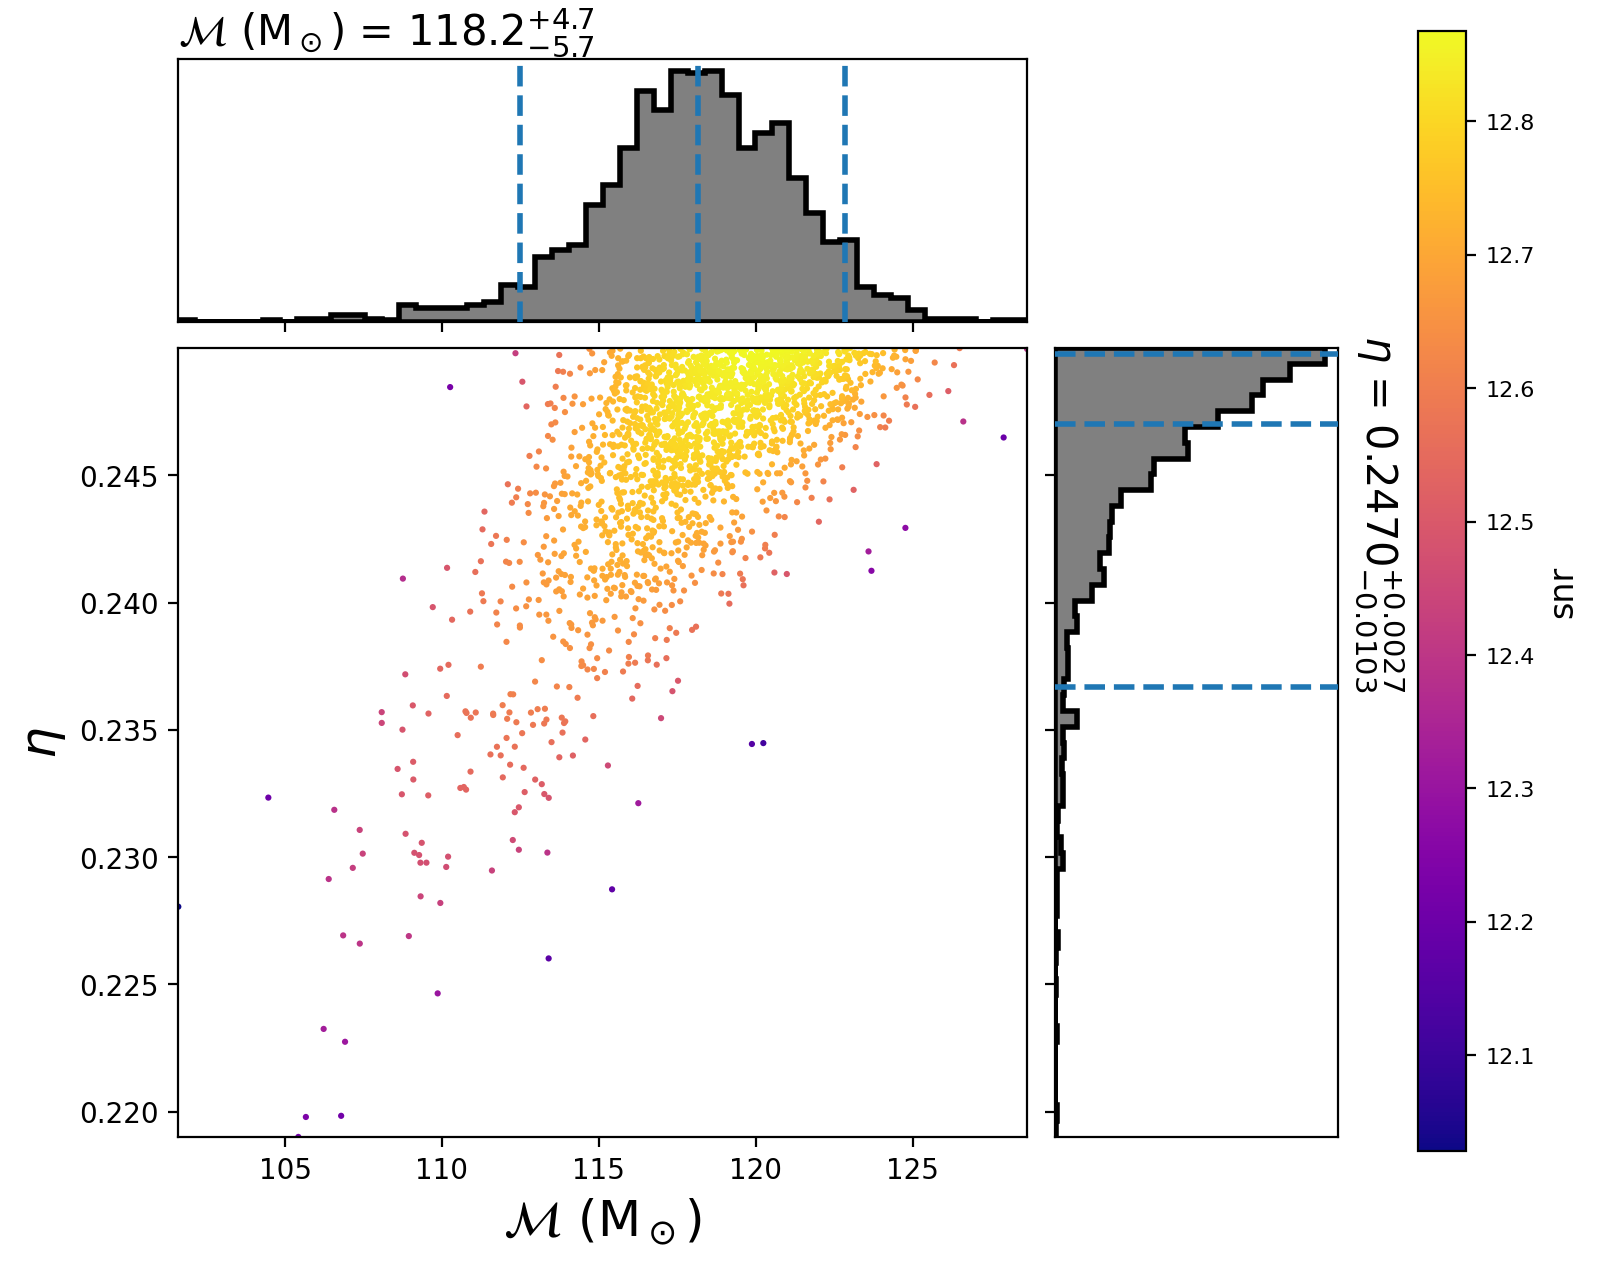

In [ ]:
Image('posterior.png', height=480)

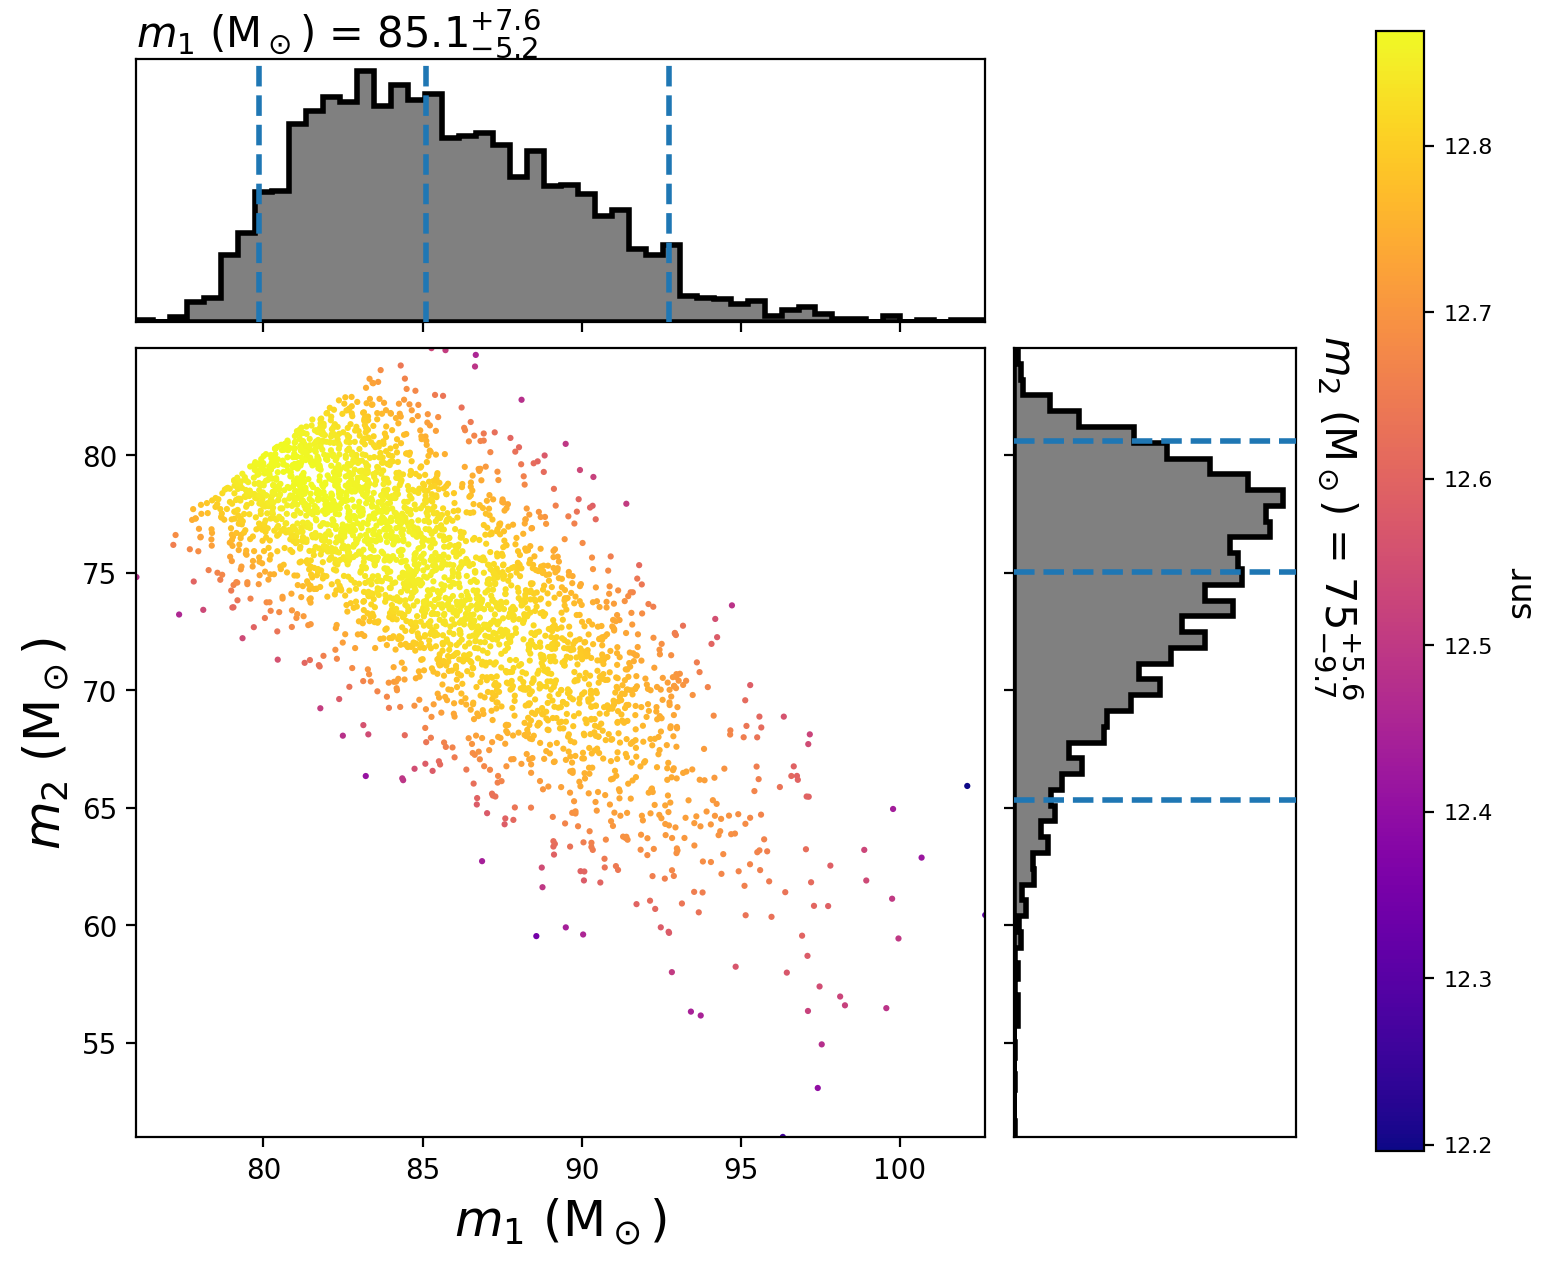

In [ ]:
Image('posterior.png', height=480)

In [ ]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses.hdf \
    --output-file posterior.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters '(primary_mass(mass1,mass2))/1.72:mass1' '(secondary_mass(mass1,mass2))/1.72:mass2'

2021-01-21 11:43:36,866 Reading input file inference-masses.hdf
2021-01-21 11:43:36,868 Loading samples
2021-01-21 11:43:36,875 Loaded 3000 samples
2021-01-21 11:43:36,877 Plotting
2021-01-21 11:43:39,588 Done


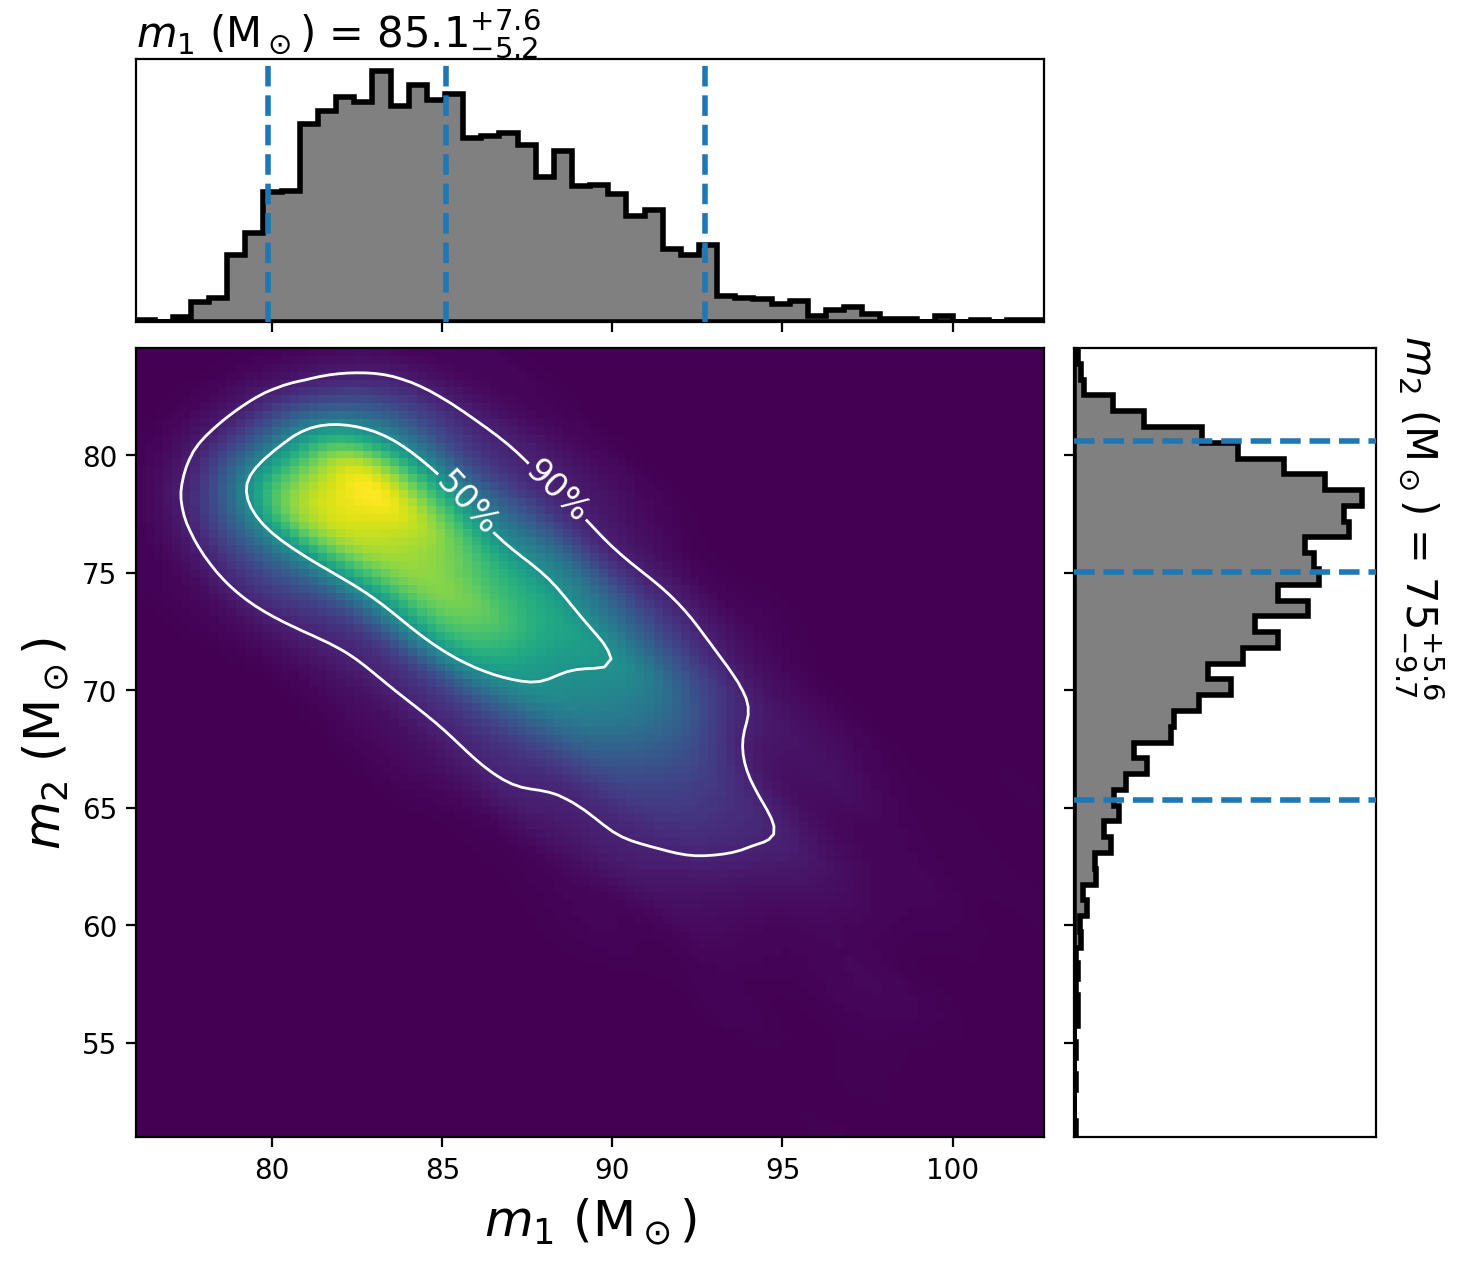

In [ ]:
Image('posterior.png', height=480)

### Suggested problems:
 1. Plot source-frame chirp mass instead.
 2. Repeat the above, but use a prior uniform in mass1 and mass2. Do the results look converged after just 400 iterations? If not, try increasing the number of iterations. Also try increasing the number of temperatures. Note that this will take longer to analyze as a result. When plotting the results, notice that there are points where mass2 > mass1. Replot with mass1 > mass2. You can do that by using the `primary_mass` and `secondary_mass` functions.
 3. Repeat the same, but use a prior uniform in source-frame masses. See the example BBH prior config [here](https://github.com/gwastro/pycbc/blob/v1.16.12/examples/inference/priors/bbh-uniform_comoving_volume.ini) for help.

## Different approximants

In [ ]:
model_config = """
[model]
name = relative
low-frequency-cutoff = 14
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 157.2
mass2_ref = 114.9
tc_ref = ${data|trigger-time}
"""

In [ ]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
low-frequency-cutoff = 14
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 157.2
mass2_ref = 114.9
tc_ref = ${data|trigger-time}



In [ ]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 500
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [ ]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 500
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



In [ ]:
prior_config = """
[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 14.0
approximant = IMRPhenomD
polarization = 0
ra = 3.293
dec = 0.51
distance = 4700
inclination = 0.63
delta_tc = 0.0623

[prior-mass1]
name = uniform
min-mass1 = 0
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 0
max-mass2 = 160

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [ ]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 14.0
approximant = IMRPhenomD
polarization = 0
ra = 3.293
dec = 0.51
distance = 4700
inclination = 0.63
delta_tc = 0.0623

[prior-mass1]
name = uniform
min-mass1 = 0
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 0
max-mass2 = 160

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [ ]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-masses-0.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2021-01-22 10:49:02,232 Using seed 3214897
2021-01-22 10:49:02,233 Running with CPU support: 1 threads
2021-01-22 10:49:02,233 Reading configuration file
2021-01-22 10:49:02,235 Setting up model
2021-01-22 10:49:02,237 Setting up priors for each parameter
2021-01-22 10:49:02,237 No sampling_params section read from config file
2021-01-22 10:49:02,238 Loading waveform transforms
2021-01-22 10:49:02,241 Determining analysis times to use
2021-01-22 10:49:02,242 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 10:49:02,242 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 10:49:02,242 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 10:49:02,242 Reading Frames
2021-01-22 10:49:18,437 Highpass Filtering
2021-01-22 10:49:18,505 Converting to float64
2021-01

In [ ]:
model_config = """
[model]
name = relative
low-frequency-cutoff = 14
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 157.2
mass2_ref = 114.9
tc_ref = ${data|trigger-time}
"""

In [ ]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
low-frequency-cutoff = 14
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 157.2
mass2_ref = 114.9
tc_ref = ${data|trigger-time}



In [ ]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 500
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [ ]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 250
niterations = 500
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



In [ ]:
prior_config = """
[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 14.0
approximant = IMRPhenomPv2
polarization = 0
ra = 3.293
dec = 0.51
distance = 4700
inclination = 0.63
delta_tc = 0.0623

[prior-mass1]
name = uniform
min-mass1 = 0
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 0
max-mass2 = 160

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [ ]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 14.0
approximant = IMRPhenomPv2
polarization = 0
ra = 3.293
dec = 0.51
distance = 4700
inclination = 0.63
delta_tc = 0.0623

[prior-mass1]
name = uniform
min-mass1 = 0
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 0
max-mass2 = 160

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [ ]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-masses-1.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2021-01-22 11:10:22,148 Using seed 3214897
2021-01-22 11:10:22,149 Running with CPU support: 1 threads
2021-01-22 11:10:22,149 Reading configuration file
2021-01-22 11:10:22,151 Setting up model
2021-01-22 11:10:22,152 Setting up priors for each parameter
2021-01-22 11:10:22,153 No sampling_params section read from config file
2021-01-22 11:10:22,153 Loading waveform transforms
2021-01-22 11:10:22,156 Determining analysis times to use
2021-01-22 11:10:22,156 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 11:10:22,156 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 11:10:22,156 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-22 11:10:22,157 Reading Frames
2021-01-22 11:10:38,362 Highpass Filtering
2021-01-22 11:10:38,430 Converting to float64
2021-01

Plotting the three different approximants


In [ ]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses-0.hdf inference-masses-1.hdf\
    --output-file posterior.png \
    --plot-contours --plot-marginal \
    --parameters '(primary_mass(mass1,mass2))/1.72:mass1' '(secondary_mass(mass1,mass2))/1.72:mass2'

2021-01-22 11:32:56,443 Reading input file inference-masses-0.hdf
2021-01-22 11:32:56,445 Loading samples
2021-01-22 11:32:56,453 Loaded 3500 samples
2021-01-22 11:32:56,453 Reading input file inference-masses-1.hdf
2021-01-22 11:32:56,454 Loading samples
2021-01-22 11:32:56,461 Loaded 3000 samples
2021-01-22 11:32:56,463 Plotting
2021-01-22 11:32:59,171 Done


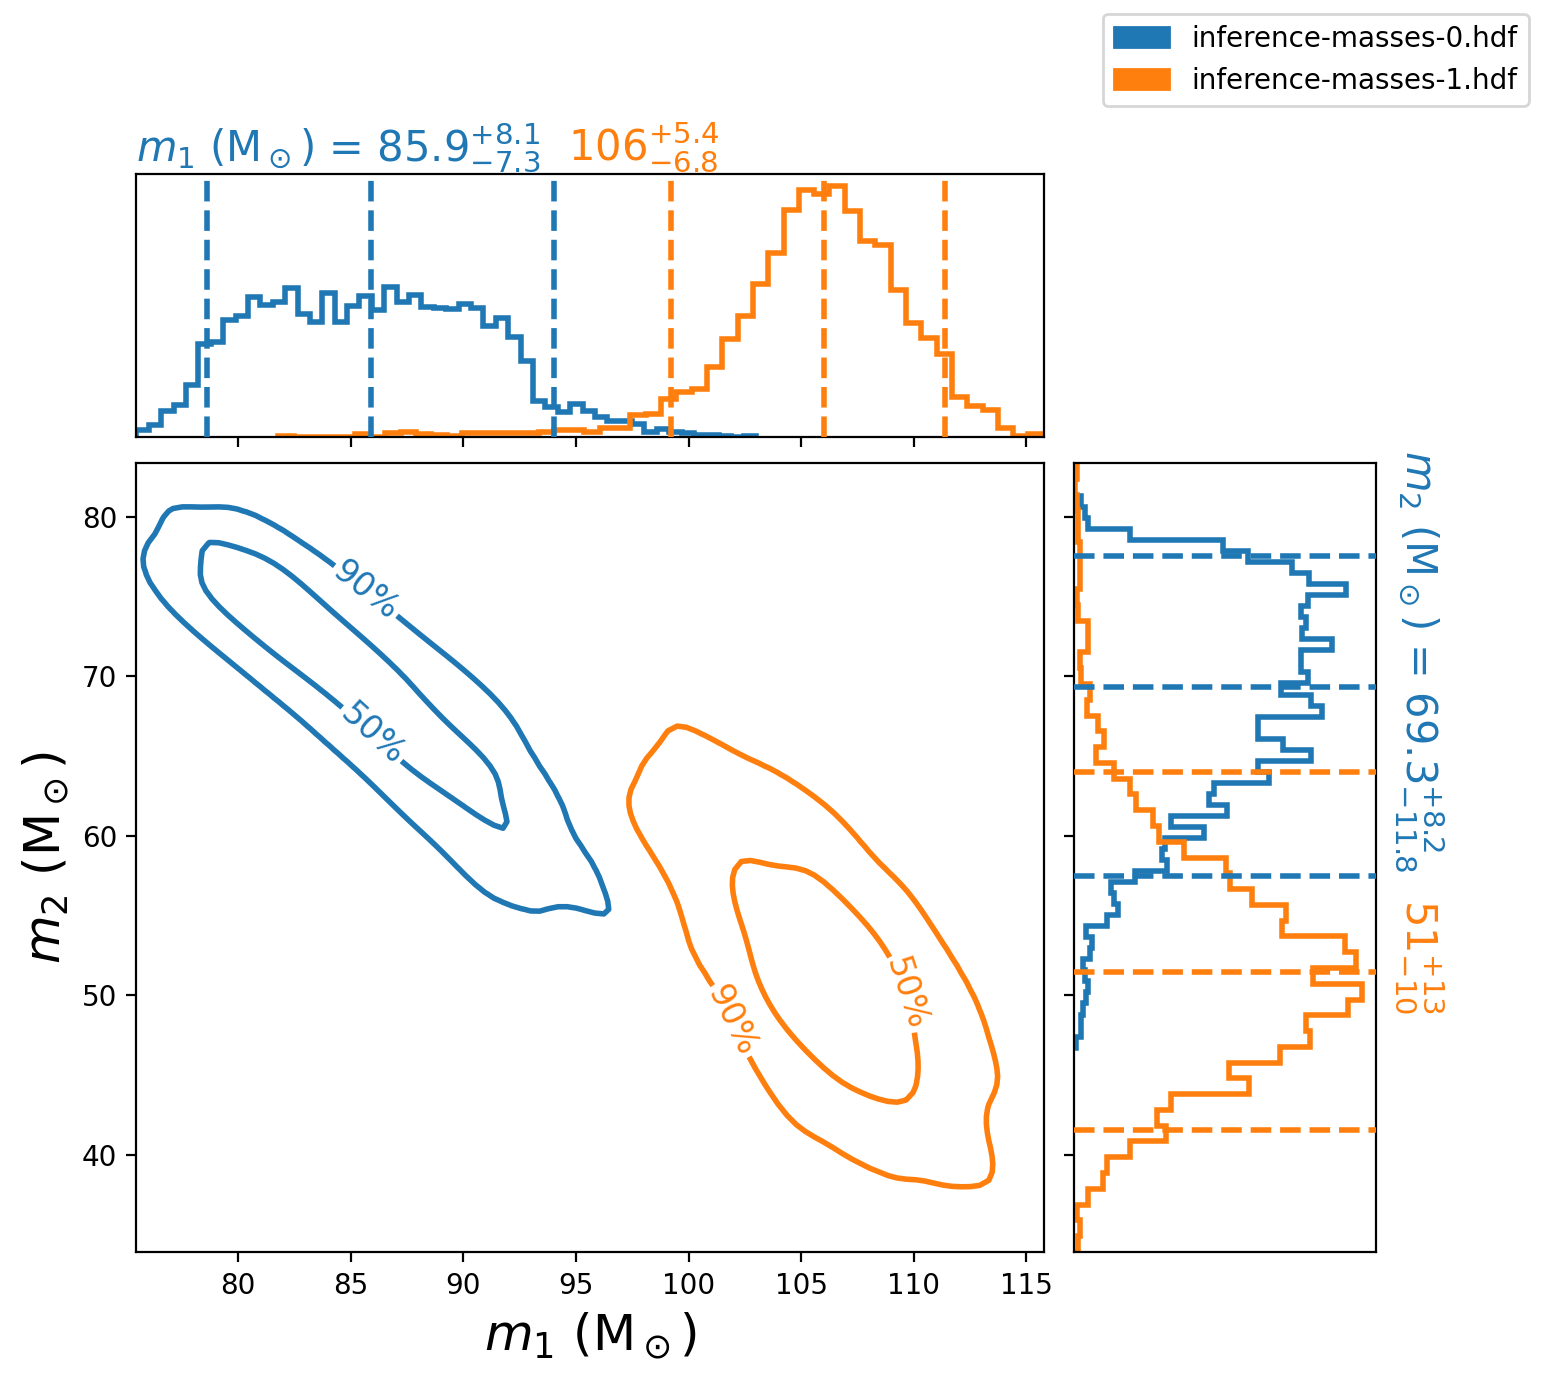

In [ ]:
Image('posterior.png', height=480)

inference-masses-0 is the PhenomPv2 \\
inference-masses-1 is the PhenomD